In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# 用于计算模型中的参数数量
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
input_size = 28*28
output_size = 10

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])),
            batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])),
            batch_size=1000, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16371671.03it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 505553.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4451257.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9789583.13it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



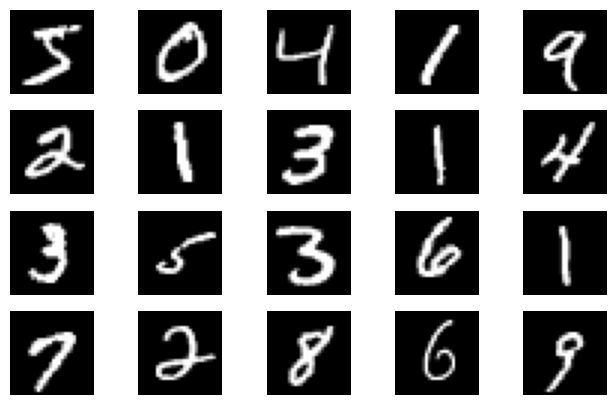

In [3]:
plt.figure(figsize=(8, 5))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    image,_ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy(),'gray')
    plt.axis('off');

In [4]:
# 不适用CNN，仅使用全连接层和激活函数的模型
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)


# 使用CNN的卷积神经网络模型
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [5]:
# 训练函数
def train(model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # 计算本次batch的损失，并加到test_loss中
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        # 值最大的对应着分类结果，保存在pred里
        pred = output.data.max(1, keepdim=True)[1]
        # 将pred与target相比，得到正确预测结果的数量，并加到correct中
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),accuracy))

In [6]:
# 在不使用CNN的神经网络中训练
n_hidden = 8
model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))
train(model_fnn)
test(model_fnn)

Number of parameters: 6442
Train: [0/60000 (0%)]	Loss: 2.362807
Train: [6400/60000 (11%)]	Loss: 1.904304
Train: [12800/60000 (21%)]	Loss: 1.645283
Train: [19200/60000 (32%)]	Loss: 1.010016
Train: [25600/60000 (43%)]	Loss: 0.846110
Train: [32000/60000 (53%)]	Loss: 0.502642
Train: [38400/60000 (64%)]	Loss: 0.463231
Train: [44800/60000 (75%)]	Loss: 0.579035
Train: [51200/60000 (85%)]	Loss: 0.374319
Train: [57600/60000 (96%)]	Loss: 0.483494

Test set: Average loss: 0.4438, Accuracy: 8711/10000 (87%)



In [7]:
# 在卷积神经网络上训练
n_features = 6
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))
train(model_cnn)
test(model_cnn)

Number of parameters: 6422
Train: [0/60000 (0%)]	Loss: 2.312745
Train: [6400/60000 (11%)]	Loss: 1.252755
Train: [12800/60000 (21%)]	Loss: 0.339864
Train: [19200/60000 (32%)]	Loss: 0.450471
Train: [25600/60000 (43%)]	Loss: 0.189272
Train: [32000/60000 (53%)]	Loss: 0.318538
Train: [38400/60000 (64%)]	Loss: 0.183152
Train: [44800/60000 (75%)]	Loss: 0.169843
Train: [51200/60000 (85%)]	Loss: 0.075842
Train: [57600/60000 (96%)]	Loss: 0.253173

Test set: Average loss: 0.1506, Accuracy: 9537/10000 (95%)



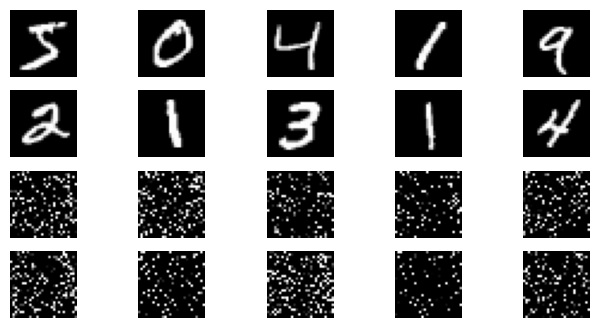

In [8]:
# torch.randperm 函数，给定参数n，返回一个从0到n-1的随机整数排列
perm = torch.randperm(784)
#打乱图像的像素分布
plt.figure(figsize=(8, 4))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy(), 'gray')
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy(), 'gray')
    plt.axis('off')

In [9]:
# 对每个 batch 里的数据，打乱像素顺序的函数
def perm_pixel(data, perm):
    # 转化为二维矩阵
    data_new = data.view(-1, 28*28)
    # 打乱像素顺序
    data_new = data_new[:, perm]
    # 恢复为原来4维的 tensor
    data_new = data_new.view(-1, 1, 28, 28)
    return data_new

# 训练函数
def train_perm(model, perm):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # 像素打乱顺序
        data = perm_pixel(data, perm)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# 测试函数
def test_perm(model, perm):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        # 像素打乱顺序
        data = perm_pixel(data, perm)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),accuracy))

In [10]:
# 在不使用CNN的神经网络上训练
perm = torch.randperm(784)
n_hidden = 8 # number of hidden units
model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))
train_perm(model_fnn, perm)
test_perm(model_fnn, perm)

Number of parameters: 6442
Train: [0/60000 (0%)]	Loss: 2.355136
Train: [6400/60000 (11%)]	Loss: 1.761463
Train: [12800/60000 (21%)]	Loss: 1.164537
Train: [19200/60000 (32%)]	Loss: 0.767672
Train: [25600/60000 (43%)]	Loss: 0.547843
Train: [32000/60000 (53%)]	Loss: 0.447395
Train: [38400/60000 (64%)]	Loss: 0.748010
Train: [44800/60000 (75%)]	Loss: 0.586761
Train: [51200/60000 (85%)]	Loss: 0.453796
Train: [57600/60000 (96%)]	Loss: 0.504623

Test set: Average loss: 0.4396, Accuracy: 8660/10000 (87%)



In [11]:
# 在卷积神经网络上训练
perm = torch.randperm(784)
n_features = 6 # number of feature maps
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))
train_perm(model_cnn, perm)

Number of parameters: 6422
Train: [0/60000 (0%)]	Loss: 2.333584
Train: [6400/60000 (11%)]	Loss: 2.280640
Train: [12800/60000 (21%)]	Loss: 2.232283
Train: [19200/60000 (32%)]	Loss: 1.962299
Train: [25600/60000 (43%)]	Loss: 1.730381
Train: [32000/60000 (53%)]	Loss: 1.277597
Train: [38400/60000 (64%)]	Loss: 0.936260
Train: [44800/60000 (75%)]	Loss: 0.754532
Train: [51200/60000 (85%)]	Loss: 0.581619
Train: [57600/60000 (96%)]	Loss: 0.534131
